# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 1, 18, 27, 46, 840329)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-01-01 18:27:46,846 INFO: Initializing external client
2025-01-01 18:27:46,847 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-01 18:27:51,518 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1208490


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-01-03 00:00:00+00:00,-9.70,0.0,6.989935,281.888641,Stockholm
1,2025-01-08 00:00:00+00:00,1.60,0.0,16.622490,162.349792,Stockholm
2,2025-01-09 00:00:00+00:00,1.00,0.2,14.058450,230.194473,Stockholm
3,2025-01-10 00:00:00+00:00,-6.70,0.0,8.534353,242.354111,Stockholm
4,2025-01-05 00:00:00+00:00,-10.25,0.0,2.305125,231.340164,Stockholm
5,2025-01-06 00:00:00+00:00,0.60,0.0,22.539564,116.564987,Stockholm
6,2025-01-07 00:00:00+00:00,2.25,0.0,26.081993,200.185883,Stockholm
7,2025-01-04 00:00:00+00:00,-8.55,0.0,14.408997,257.005371,Stockholm
8,2025-01-02 00:00:00+00:00,-5.60,0.0,13.910169,259.562561,Stockholm


In [8]:
from datetime import datetime, timedelta
start_date_test_data = "2024-12-10"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.65s) 
2025-01-01 18:28:16,277 WARNING: VersionWarning: Incremented version to `7`.



In [10]:
import pandas as pd
from sklearn.utils import shuffle

def add_lagged_features_and_shuffle(X, y, lags=3, random_state=None):
    """
    Add lagged features for the target variable y and shuffle the dataset.

    Parameters:
        X (pd.DataFrame): Input features DataFrame (does not include the target).
        y (pd.Series): Target Series containing the pm25 values.
        lags (int): The number of lagged features to create (default is 3).
        random_state (int): Random state for reproducibility of the shuffle.

    Returns:
        pd.DataFrame: Adjusted features DataFrame with lagged pm25 features.
        pd.Series: Adjusted target Series with aligned rows.
    """
    # Combine X and y into a single DataFrame for processing
    data = X.copy()
    data['pm25'] = y

    # Ensure the DataFrame is sorted by date to maintain temporal order
    data = data.sort_values(by='date').reset_index(drop=True)

    # Add lagged features for pm25
    for lag in range(1, lags + 1):
        data[f'pm25_lag_{lag}'] = data['pm25'].shift(lag)
    
    # Drop rows with NaN values introduced by shifting
    data = data.dropna().reset_index(drop=True)

    # Extract the target and features after lagging
    y_adjusted = data['pm25']  # The target variable remains as `pm25`
    X_adjusted = data.drop(columns=['pm25'])  # Drop the current pm25 column from features

    # Shuffle the data
    X_adjusted, y_adjusted = shuffle(X_adjusted, y_adjusted, random_state=random_state)

    # Reset the index
    X_adjusted = X_adjusted.reset_index(drop=True)
    y_adjusted = y_adjusted.reset_index(drop=True)

    return X_adjusted, y_adjusted

In [11]:
# Example usage
X_test_adjusted, y_test_adjusted = add_lagged_features_and_shuffle(
    X=X_test,  # Remove `pm25` from X
    y=y_test,                 # Use `pm25` as the target
    lags=3,                            # Number of lagged features
    random_state=42                    # Random state for reproducibility
)

In [12]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

test_features = X_test_adjusted.drop(['date', 'city'], axis=1)

In [13]:
# Display the resulting X and y
print(X_test_adjusted.head())
print()
print(y_test_adjusted.head())

                        date  temperature_2m_mean  precipitation_sum  \
0  2024-12-13 00:00:00+00:00            -2.250833                0.0   
1  2024-12-18 00:00:00+00:00             0.855417                5.0   
2  2024-12-24 00:00:00+00:00             0.370000                0.3   
3  2024-12-14 00:00:00+00:00             1.113750                2.9   
4  2024-12-21 00:00:00+00:00             0.445000                7.3   

   wind_speed_10m_max  wind_direction_10m_dominant       city  pm25_lag_1  \
0           18.917133                   239.639954  Stockholm         0.0   
1           20.615305                   178.761749  Stockholm         0.0   
2           15.743569                   219.515137  Stockholm         1.0   
3           21.139849                   255.879990  Stockholm         0.0   
4           16.787354                   208.089081  Stockholm         0.0   

   pm25_lag_2  pm25_lag_3  
0         0.0         0.0  
1         0.0         0.0  
2         0.0       

In [14]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-01-03 00:00:00+00:00,-9.70,0.0,6.989935,281.888641,Stockholm
1,2025-01-08 00:00:00+00:00,1.60,0.0,16.622490,162.349792,Stockholm
2,2025-01-09 00:00:00+00:00,1.00,0.2,14.058450,230.194473,Stockholm
3,2025-01-10 00:00:00+00:00,-6.70,0.0,8.534353,242.354111,Stockholm
4,2025-01-05 00:00:00+00:00,-10.25,0.0,2.305125,231.340164,Stockholm
5,2025-01-06 00:00:00+00:00,0.60,0.0,22.539564,116.564987,Stockholm
6,2025-01-07 00:00:00+00:00,2.25,0.0,26.081993,200.185883,Stockholm
7,2025-01-04 00:00:00+00:00,-8.55,0.0,14.408997,257.005371,Stockholm
8,2025-01-02 00:00:00+00:00,-5.60,0.0,13.910169,259.562561,Stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [15]:
def autoregressive_inference(model, batch_data, X_test_adjusted, lags=3):
    """
    Perform autoregressive predictions for pm25 using lagged values.

    Parameters:
        model: The trained machine learning model for inference.
        batch_data (pd.DataFrame): The weather forecast data for upcoming days.
        X_test_adjusted (pd.DataFrame): The dataset containing lagged pm25 features.
        lags (int): The number of lagged pm25 features to consider.

    Returns:
        pd.DataFrame: Updated batch_data with predicted pm25 values.
    """
    # Initialize predictions list
    predictions = []

    # Start with the last known lagged values from X_test_adjusted
    lagged_pm25 = X_test_adjusted.iloc[-1][[f'pm25_lag_{i}' for i in range(1, lags + 1)]].values.tolist()

    # Iterate through each day in batch_data
    for index, row in batch_data.iterrows():
        # Create input for the model by combining weather features and lagged pm25
        model_input = row[['temperature_2m_mean', 'precipitation_sum', 
                           'wind_speed_10m_max', 'wind_direction_10m_dominant']].tolist()
        model_input.extend(lagged_pm25)  # Add lagged pm25 values

        # Predict pm25 for the current day
        predicted_pm25 = model.predict(np.array([model_input]))[0]
        predictions.append(predicted_pm25)

        # Update lagged pm25 values for the next day
        lagged_pm25 = [predicted_pm25] + lagged_pm25[:-1]  # Shift and add new prediction

    # Add predictions to batch_data
    batch_data['predicted_pm25'] = predictions

    return batch_data

In [16]:
import numpy as np
# Example usage
batch_data = autoregressive_inference(retrieved_xgboost_model, batch_data, X_test_adjusted, lags=3)

# Display the updated batch_data
print(batch_data)

                       date  temperature_2m_mean  precipitation_sum  \
0 2025-01-03 00:00:00+00:00                -9.70                0.0   
1 2025-01-08 00:00:00+00:00                 1.60                0.0   
2 2025-01-09 00:00:00+00:00                 1.00                0.2   
3 2025-01-10 00:00:00+00:00                -6.70                0.0   
4 2025-01-05 00:00:00+00:00               -10.25                0.0   
5 2025-01-06 00:00:00+00:00                 0.60                0.0   
6 2025-01-07 00:00:00+00:00                 2.25                0.0   
7 2025-01-04 00:00:00+00:00                -8.55                0.0   
8 2025-01-02 00:00:00+00:00                -5.60                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant       city  predicted_pm25  
0            6.989935                   281.888641  Stockholm        1.887329  
1           16.622490                   162.349792  Stockholm        4.856068  
2           14.058450                   230.19447

In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         9 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          9 non-null      float32                
 2   precipitation_sum            9 non-null      float32                
 3   wind_speed_10m_max           9 non-null      float32                
 4   wind_direction_10m_dominant  9 non-null      float32                
 5   city                         9 non-null      object                 
 6   predicted_pm25               9 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 452.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [18]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
8,2025-01-02 00:00:00+00:00,-5.60,0.0,13.910169,259.562561,Stockholm,5.807897,Lillies väg,Sweden,9
0,2025-01-03 00:00:00+00:00,-9.70,0.0,6.989935,281.888641,Stockholm,1.887329,Lillies väg,Sweden,1
7,2025-01-04 00:00:00+00:00,-8.55,0.0,14.408997,257.005371,Stockholm,0.294461,Lillies väg,Sweden,8
4,2025-01-05 00:00:00+00:00,-10.25,0.0,2.305125,231.340164,Stockholm,7.634370,Lillies väg,Sweden,5
5,2025-01-06 00:00:00+00:00,0.60,0.0,22.539564,116.564987,Stockholm,5.200579,Lillies väg,Sweden,6
6,2025-01-07 00:00:00+00:00,2.25,0.0,26.081993,200.185883,Stockholm,3.976411,Lillies väg,Sweden,7
1,2025-01-08 00:00:00+00:00,1.60,0.0,16.622490,162.349792,Stockholm,4.856068,Lillies väg,Sweden,2
2,2025-01-09 00:00:00+00:00,1.00,0.2,14.058450,230.194473,Stockholm,9.608504,Lillies väg,Sweden,3
3,2025-01-10 00:00:00+00:00,-6.70,0.0,8.534353,242.354111,Stockholm,8.200059,Lillies väg,Sweden,4


In [19]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 8 to 3
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         9 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          9 non-null      float32                
 2   precipitation_sum            9 non-null      float32                
 3   wind_speed_10m_max           9 non-null      float32                
 4   wind_direction_10m_dominant  9 non-null      float32                
 5   city                         9 non-null      object                 
 6   predicted_pm25               9 non-null      float32                
 7   street                       9 non-null      object                 
 8   country                      9 non-null      object                 
 9   days_before_forecast_day     9 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

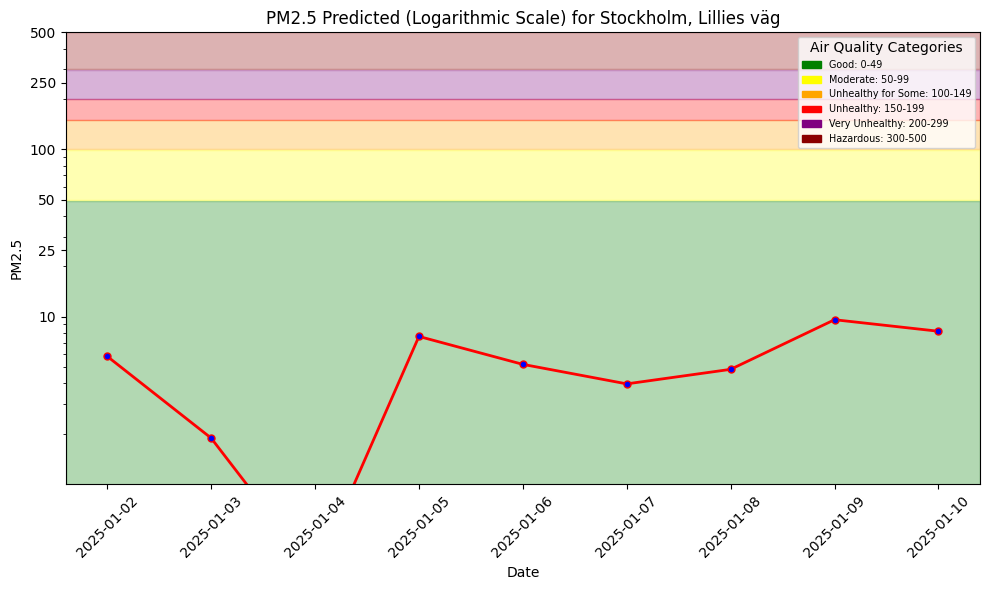

In [20]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [21]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [22]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1208490/fs/1195097/fg/1393443


Uploading Dataframe: 100.00% |████████████████████████████████████████████████| Rows 9/9 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1208490/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-01-01 18:28:37,228 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-01 18:28:43,669 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-01 18:30:21,382 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-01 18:30:21,675 INFO: Waiting for log aggregation to finish.
2025-01-01 18:30:45,392 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [23]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.75s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-01-03 00:00:00+00:00,-9.7,0.0,6.989935,281.888641,Stockholm,1.887329,Lillies väg,Sweden,1


In [24]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


,date,pm25,country,city,street,url
0,2022-03-19 00:00:00+00:00,1.0,Sweden,Stockholm,Lillies väg,https://api.waqi.info/feed/A110455
1,2020-04-24 00:00:00+00:00,2.0,Sweden,Stockholm,Lillies väg,https://api.waqi.info/feed/A110455
2,2021-03-21 00:00:00+00:00,0.0,Sweden,Stockholm,Lillies väg,https://api.waqi.info/feed/A110455
3,2022-12-20 00:00:00+00:00,3.0,Sweden,Stockholm,Lillies väg,https://api.waqi.info/feed/A110455
4,2021-07-13 00:00:00+00:00,3.0,Sweden,Stockholm,Lillies väg,https://api.waqi.info/feed/A110455
...,...,...,...,...,...,...
1731,2024-02-23 00:00:00+00:00,2.0,Sweden,Stockholm,Lillies väg,https://api.waqi.info/feed/A110455
1732,2023-10-24 00:00:00+00:00,0.0,Sweden,Stockholm,Lillies väg,https://api.waqi.info/feed/A110455
1733,2023-10-23 00:00:00+00:00,0.0,Sweden,Stockholm,Lillies väg,https://api.waqi.info/feed/A110455
1734,2022-03-11 00:00:00+00:00,3.0,Sweden,Stockholm,Lillies väg,https://api.waqi.info/feed/A110455


In [26]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, X_test_adjusted)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 


Uploading Dataframe: 100.00% |████████████████████████████████████████████████| Rows 1/1 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1208490/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-01-01 18:32:53,409 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-01 18:32:57,014 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-01 18:34:40,255 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-01 18:34:40,464 INFO: Waiting for log aggregation to finish.
2025-01-01 18:35:03,482 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-01-01 00:00:00+00:00,-0.55,0.0,10.895576,7.59456,Stockholm,0.36369,0.0,Lillies väg,Sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

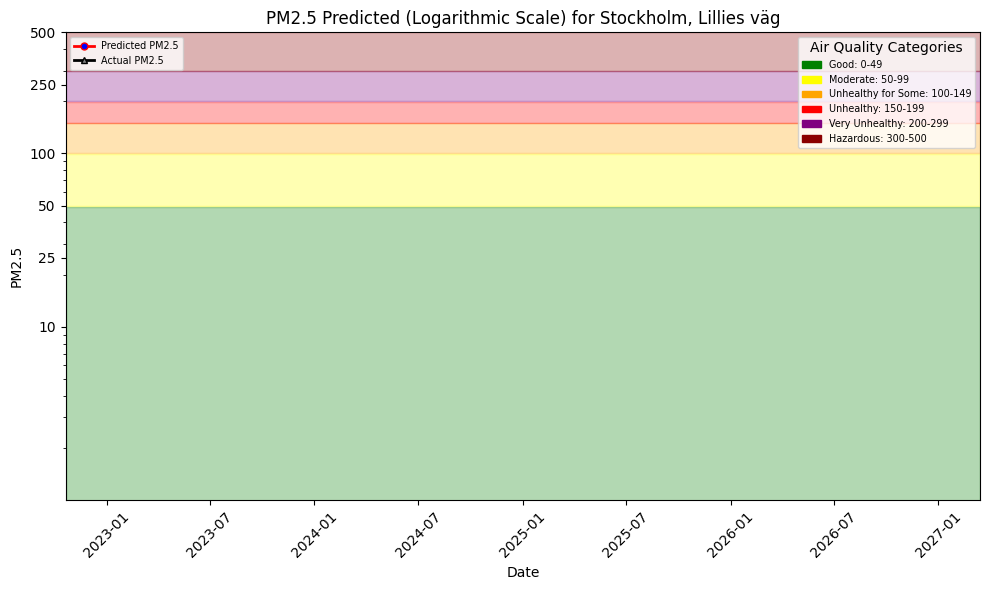

In [27]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---